# CNNの実装、GPUでの計算

この章では、前章で学んだCNNの構造を踏まえて、Chainerを用いたCNNの実装方法やGPUでの計算方法について学んでいきます。





## 問題設定

CNNの中身を理解したところで早速、実装に移っていきます。
それでは、サンプルとして有名である`MNIST`という0～9までの10種類の手書き数字の認識を行ってみます。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## データセットの読み込み

`MNIST`に関してはchainerが用意しているため`get_mnist`をインポートし、データセットを読み込みます。

In [2]:
from chainer.datasets import get_mnist

`ndim=3` と引数を指定することで、CNNに適した形式でデータセットを取得することができます。

In [3]:
train_val, test = get_mnist(ndim=3)

サンプルとしてはデータセットの準備が不要で、CNNのモデル構築の練習になります。
しかし、最終的に自作のデータセットに対して適用していくことを考えると、どのようなデータセットの形式であればよいかわからないのはまずいことです。
そのため、データセットの形式をまず確認しておきます。

In [4]:
train_val

In [5]:
len(train_val)

60000

In [6]:
test

In [7]:
len(test)

10000

In [8]:
from chainer.datasets import split_dataset_random

train, valid = split_dataset_random(train_val, 50000, seed=0)


変数名を打って確認してみますが、どのような形式かわかりません。

このchainerのデータセット形式はリストのような形式になっており、各サンプルに`（画像、ラベル）`のようにタプル形式で格納されています。

- train[0]: １サンプル目の(画像、ラベル)が格納
- train[0][0]: １サンプル目の画像（float32）
- train[0][1]: １サンプル目のラベル（int32）


サイズ等を確認します。

In [9]:
type(train[0][0])

numpy.ndarray

In [10]:
train[0][0].shape  # 後述

(1, 28, 28)

28×28のサイズ、1チャンネルで入っていることが確認できました。

In [11]:
train[0][0].dtype

dtype('float32')

In [12]:
type(train[0][1])

numpy.int32

しっかりと32bitのnumpy形式で格納されていることも確認できました。

In [13]:
train[0][1].shape

()

In [14]:
train[0][1].dtype

dtype('int32')

ここでわかることとして、画像が(height, width, channel)の順ではなく、(channel, height, width)の順に格納されていることです。

CNNで扱う際には、この順に並べておかないといけないため、覚えておいてください。  
画像を表示させる際には、(height, width, channel)の順に戻しておく必要があるため、`transpose`を使用して順番を入れ替え、試しに１枚目をプロットしてみます。

In [15]:
# (channel:0 , height:1, width:2) -> (height:1, width:2, channel:0)
img = np.transpose(train[0][0], (1, 2, 0))

In [16]:
img.shape

(28, 28, 1)

グレースケールでは最後の (.., .. ,1)の部分が邪魔になってエラーとなってしまうため、この部分をうまく取り除きます。

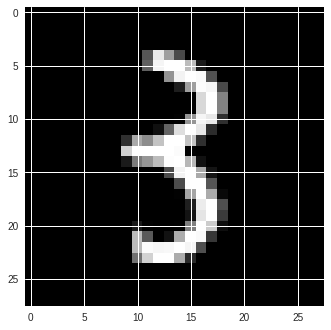

In [17]:
plt.gray()
plt.imshow(img.reshape(28, 28))

こちらのように手書き文字の3がデータとして格納されていることがわかりました。  
データセットの形式を確認しながら試行錯誤する癖をつけておくようにしてください。

## CNNモデルの定義

それでは、画像処理で近年では定番となっているConvolutional Neural Network（CNN）の実装を行っていきます。  
まずは、chainerでよく使用するモジュールを読み込みます。

In [18]:
import chainer
import chainer.links as L
import chainer.functions as F

class内を定義していきます。今回は以下のような構造のCNNを作成します。

![CNNの構造](images/11/01.png)


In [19]:
class CNN(chainer.Chain):
    
    def __init__(self, n_mid=100, n_out=10):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=1, out_channels=3, ksize=3, stride=1, pad=1)
            self.fc1 = L.Linear(None, n_mid)
            self.fc2 = L.Linear(None, n_out)

    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 3, 3)
        h = self.fc1(h)
        h = self.fc2(h)
        return h

### CNNのネットワークの中身

#### init関数内

畳み込みの計算には`chainer.links.Convolution2D`を使用します。  
引数には前章で紹介した構成要素が入っていることが確認できます。  

`in_channels`には入力となる画像のchannel数を指定します。  
もしConvolution（畳み込み）を複数回行う際には増えたchannel数に合わせて変更する必要があります。  

`out_channels`は畳み込みごに出力となるchannel数になります。  
この数値は人間側が任意で決める必要のあるハイパーパラメータになります。  

`ksize`はカーネル（フィルタ）のサイズを指定します。  
基本的には3を使用します。指定方法はタプル型で縦、横の長さを指定することも可能です。  
（`3`は`(3,3)`と同義になります。）  

`stride`はストライドを、`pad`はパディングをあらわしています。  


#### call関数内

`F.maxpooling(h,3,3)`はMaxPoolingを示しています。  
MaxPoolingは学習するパラメータを持たないためChainer.Functionsの中に準備されています。  
また、引数は順に計算する値、カーネルサイズ、パディングの値を指定しています。  

### CPUでの実装

まずは、CPUで実装します。  
ネットワークの定義の部分では少し異なる部分がありましたが、その他の部分に関してはほとんどニューラルネットワークの実装方法と変更はありません。  

モデルとなるクラスを定義したため、インスタンス化して、そのパラメータをOptimizerで調整していきます。
モデルのインスタンス化の際にはシードを固定して**再現性の確保**ができるように気を付けてください。

`np.random.seed(0)`



In [20]:
np.random.seed(0)

In [21]:
# インスタンス化
model = L.Classifier(CNN())

In [22]:
gpu_id = -1  # CPUの使用を宣言

In [23]:
# Optimizerの定義とmodelとの紐づけ
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

ミニバッチ学習のバッチサイズを決定して、SeriallIteratorでバッチごとに分割します。

In [24]:
batchsize = 4096
train_iter = chainer.iterators.SerialIterator(train, batchsize)
valid_iter = chainer.iterators.SerialIterator(valid, batchsize, repeat=False, shuffle=False)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

Updater、Extensions、Trainerの定義をします。

In [25]:
from chainer import training
from chainer.training import extensions

epoch = 30

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

trainer = training.Trainer(updater, (epoch, 'epoch'), out='mnist')

# バリデーション用のデータで評価
trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id))

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

# １エポックごとに結果をlogファイルに出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

設定が完了したため、trainerで学習を開始します。

In [26]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.425143       0.685532                  1.82843     1.33018               13.7039       
2           0.736348       0.783009                  1.09776     0.862582              26.5211       
3           0.805054       0.827364                  0.751719    0.636924              39.5725       
4           0.84198        0.849881                  0.584268    0.522144              52.4798       
5           0.861854       0.868785                  0.491363    0.450459              66.279        
6           0.876017       0.880419                  0.43467     0.409145              79.1233       
7           0.884359       0.887991                  0.399271    0.378996              91.8775       
8           0.890666       0.893009                  0.372702    0.35816               104.905       
9           0.89683        0.898515                  0.353049    0.339999           

サンプル数は6万枚と多めのデータセットではありますが、画像サイズは小さく、非常にシンプルなCNN構造でありなのにも関わらず、7分半もかかってしまいました。CPUで計算しているためこれは仕方がない点ではあります。この速度を改善するために、基本的には画像などではGPUを扱うのがメインとなっておりますので、今からGoogleColab上でのGPU使用方法についてお伝えします。


### GPUでの実装

まずは、GoogleColab上でGPUが使用できる状態に変更します。

メニューバーの「ランタイム」>「ランタイムのタイプを変更」をクリックし、「ハードウェア アクセラレータ」をGPUに変更してください。

これで準備完了です。GPUが利用可能であるかを確認してみましょう。



In [27]:
import chainer
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


GPUとcuDNNがともにTrueとなっていれば大丈夫です。cuDNNとは、NVIDIA社が開発し、GPUに最適化されたディープラーニング開発用のパッケージのことを言います。利用できることが確認できたところで早速実装までおこないます。

#### シードの固定

CPU実装時と同様にシードの固定を行います。

ただし、ここで気を付けないといけないこととして、numpyのシードを固定すると良いのですが、GPUで演算を行うときは`cupy`へと引き渡されるため、すべてのシードを固定しておく必要があり、この関数（`reset_seed`）を作っておくと便利です。

In [28]:
import random 

def reset_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

こちらの関数をもとに、CPU、GPU問わずシードを固定します。
cudaに関するif文では、GPU搭載されていないマシンの時にcupyを読み込めないため、その回避策として挿入しています。

なお、引数の部分で記載していますが、デフォルトのseedは0としています。

In [29]:
# CPUとGPU関連のシードをすべて固定
reset_seed(0)

In [30]:
# インスタンス化
model = L.Classifier(CNN())

GPUを使用する場合は、`to_gpu()`を使用し、modelをGPUへ転送しておきます。  
ここで定義している`gpu_id`はどのマシンで計算するかをしてします。    
GPUを使用する際には`0`を、CPUの場合は`-1`を設定します。  

In [31]:
gpu_id = 0  # 使用したGPUに割り振られているID
model.to_gpu(gpu_id)

In [32]:
# Optimizerの定義とmodelとの紐づけ
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

ミニバッチ学習のバッチサイズを決定して、SeriallIteratorでバッチごとに分割します。

In [33]:
batchsize = 4096
train_iter = chainer.iterators.SerialIterator(train, batchsize)
valid_iter = chainer.iterators.SerialIterator(valid, batchsize, repeat=False, shuffle=False)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

更新規則をまとめているUpdaterを定義します。

標準的なStandardUpdaterを使用していますが、複数GPUを使用するときには、ParallelUpdaterなど適宜条件に合わせて変更していきます。  

またUpdater、Evaluator（検証データの精度を計算する）の定義の際にも`gpu_id`を渡す必要がある点に注意します。

In [34]:
from chainer import training
from chainer.training import extensions

epoch = 30

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

trainer = training.Trainer(updater, (epoch, 'epoch'), out='mnist')

# バリデーション用のデータで評価
trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id))

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

# １エポックごとに結果をlogファイルに出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

設定が完了したため、trainerで学習を開始します。

In [35]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.359112       0.672939                  1.99333     1.45219               9.83383       
2           0.73468        0.794762                  1.18506     0.923352              10.4276       
3           0.810669       0.836347                  0.796       0.668213              11.0216       
4           0.845174       0.854051                  0.605392    0.541415              11.597        
5           0.862605       0.866794                  0.507106    0.466506              12.2073       
6           0.875285       0.877712                  0.445135    0.42285               12.7945       
7           0.882792       0.884688                  0.409387    0.39237               13.3653       
8           0.888529       0.890747                  0.384513    0.36935               13.945        
9           0.894531       0.896437                  0.361479    0.351774           

GPUでの実装が終わりました。CPUの時と同じ条件で実装したにもかかわらず、たったの26秒で学習が終了し、CPUの時と比べると10倍以上速くなりました。
CPUとGPUの速度の違いを実感していただけましたでしょうか。このようにGPUを使用したときの速度が圧倒的に早いため、このGoogleColab上で無料でGPUを使用できることは非常に便利です。

結果の可視化まで行いましょう。

![](images/parallel/20.PNG)

学習の記録はlogファイルに記載されているため、推移を可視化してみます。

In [36]:
import json
import pandas as pd

In [37]:
with open('mnist/log') as f:
    result = pd.DataFrame(json.load(f))

In [38]:
# 結果の表示
result

,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
0,9.833828,1,13,0.359112,1.993328,0.672939,1.452192
1,10.427638,2,25,0.734680,1.185063,0.794762,0.923352
2,11.021647,3,37,0.810669,0.796000,0.836347,0.668213
3,11.597017,4,49,0.845174,0.605392,0.854051,0.541415
4,12.207337,5,62,0.862605,0.507106,0.866794,0.466506
5,12.794550,6,74,0.875285,0.445135,0.877712,0.422850
6,13.365323,7,86,0.882792,0.409387,0.884688,0.392370
7,13.945045,8,98,0.888529,0.384513,0.890747,0.369350
8,14.525622,9,110,0.894531,0.361479,0.896437,0.351774
9,15.159310,10,123,0.899959,0.343021,0.899838,0.335982


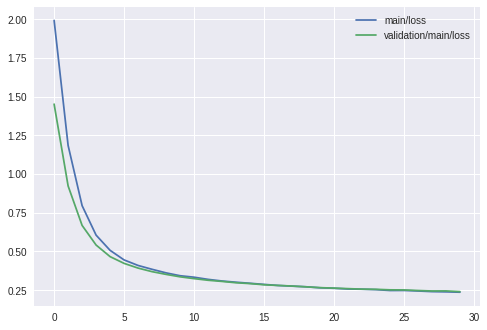

In [39]:
# 損失関数(loss)
result[['main/loss', 'validation/main/loss']].plot()

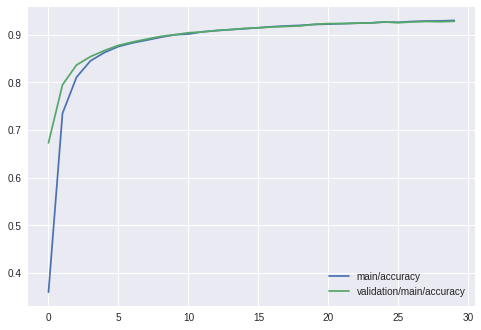

In [40]:
# 精度(accuracy)
result[['main/accuracy', 'validation/main/accuracy']].plot()

こちらのようにうまく学習できていること様子が確認できます。
オーバーフィッティングすることもなく、学習できています。

## 学習済みモデルを保存

CNNでも学習済みモデルの保存方法は同じです。  

### モデルをCPUに転送
これからモデルを保存するにあたり、CPU側にモデルを転送しておかないとエラーが出てしまいます。
意外と忘れがちな操作なのでよく覚えておいてください。

In [41]:
model.to_cpu()

### モデルのセーブ
モデルの名前と学習済みモデルを指定します。

In [42]:
chainer.serializers.save_npz('model_mnist.npz', model)

## 学習済みモデルによる推論
訓練に使用したデータですが、実際にうまく推論できるかを確認します。

学習済みモデルのロードから始めていきます。

### 学習済みモデルのロード

学習済みモデルは単にファイルをロードするだけでなく、まずはモデルの構造を明示しておき、そのモデルに対して、パラメータの値を当てはめながらロードしていくことになります。

In [43]:
model = L.Classifier(CNN())

In [44]:
chainer.serializers.load_npz('model_mnist.npz', model)

### 推論

訓練データの1枚目を使用し、推論を行います。  
今回は訓練データを使用して推論を行うため特別な処理は必要ありませんが、新たなデータを推論させる際には学習時に使用した画像データの形式に変換（前処理）を行う必要がある点も覚えて置いてください。（その他の機械学習の手法と同様に）

In [45]:
x, t = train[0]

In [46]:
t

3

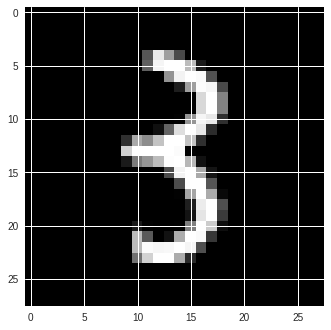

In [47]:
plt.imshow(x.reshape(28, 28))

In [48]:
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y = model.predictor(np.array([x], 'f'))

予測値`y`の値を確認してわかる通り、各クラスに属する値の回帰であるため、まだ分類の結果とは言えません。

In [49]:
y

variable([[-2.612027 ,  1.0188488, -1.0129777,  5.6842365, -1.4658473,
            1.9359924, -3.3851867, -2.7561214,  2.248133 ,  0.5093903]])

`softmax`関数をかけることで、総和が1となる確率の形式で表現できます。

In [50]:
y = F.softmax(y)
y

variable([[2.3238509e-04, 8.7715778e-03, 1.1499175e-03, 9.3160075e-01,
           7.3111890e-04, 2.1947650e-02, 1.0725787e-04, 2.0120041e-04,
           2.9988101e-02, 5.2701463e-03]])

In [51]:
np.sum(y)

variable(1.0000001)

In [52]:
y = y.array

In [53]:
type(y)

numpy.ndarray

In [54]:
np.argmax(y, axis=1)

array([3])

要素番号が3と推測されており、教師データである3と見事に一致します。

次のデータセットでも確認してみます。

In [55]:
x, t = train[1]

In [56]:
t

6

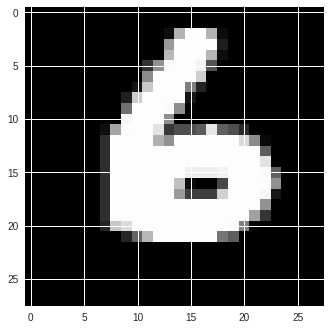

In [57]:
plt.imshow(x.reshape(28, 28))

In [58]:
y = model.predictor(np.array([x], 'f'))
y = F.softmax(y).array
np.argmax(y, axis=1)

array([6])

こちらも正しく分類できていました。
誤差が0ではないため、間違いがあることは許容していく必要があります。

次章では、サンプルのMNISTではなく実際の画像を読み込み、CNNの実装までを行っていきます。